# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/May/66393287_arvato_data.tar/arvato_data.tar.gz) from the classroom, and upload it into the workspace. After you upload the tar file to the appropriate directory, **/cd0549_bertelsmann_arvato_project_workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory from where you ran the command. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 

In [19]:
# !pip install seaborn # For data visualization if not already installed
# !pip install imbalanced-learn # For SMOTE installation if not already installed

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/x9/55cdq9mj5msby1f05d6s0r3m0000gp/T/ipykernel_10434/4183925281.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/x9/55cdq9mj5msby1f05d6s0r3m0000gp/T/ipykernel_10434/4183925281.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Quick Data Overview

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# Load datasets
print("Loading data...")
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=5000)  # Load first 5000 for speed
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=5000)

print("Data loaded successfully!\n")

# Basic exploration
print("="*60)
print("DATASET SHAPES")
print("="*60)
print(f"AZDIAS: {azdias.shape}")
print(f"CUSTOMERS: {customers.shape}")

print("\n" + "="*60)
print("FIRST 5 ROWS - FIRST 10 COLUMNS (AZDIAS)")
print("="*60)
print(azdias.iloc[:5, :10])

print("\n" + "="*60)
print("DATA TYPES")
print("="*60)
print(azdias.dtypes.value_counts())

print("\n" + "="*60)
print("MISSING VALUES (Top 20 columns with most missing)")
print("="*60)
missing = azdias.isnull().sum().sort_values(ascending=False)
print(missing.head(20))

print("\n" + "="*60)
print("SAMPLE VALUES FROM FIRST 10 COLUMNS")
print("="*60)
for col in azdias.columns[:10]:
    print(f"\n{col}: {azdias[col].unique()[:10]}")

print("\n" + "="*60)
print("CHECKING FOR SPECIAL MISSING CODES")
print("="*60)
# Check for common missing value indicators
for col in azdias.columns[:10]:
    if azdias[col].dtype in ['int64', 'float64']:
        if -1 in azdias[col].values:
            print(f"{col}: Contains -1")
        if 0 in azdias[col].values:
            print(f"{col}: Contains 0")

Loading data...
Data loaded successfully!

DATASET SHAPES
AZDIAS: (1000, 366)
CUSTOMERS: (1000, 369)

FIRST 5 ROWS - FIRST 10 COLUMNS (AZDIAS)
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  
0          NaN          NaN                   NaN                  NaN  
1          NaN          NaN                  21.0                 11.0  
2          NaN          NaN                  17.0                 10.0  
3          NaN          NaN                  13.0                  1.0  
4          NaN          NaN                  14.0                

##  Let's Investigate Deeper

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load first 5000 rows for better sample
print("Loading data...")
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=5000)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=5000)

print("="*70)
print("STEP 1: IDENTIFY OBJECT (STRING) COLUMNS")
print("="*70)
object_cols = azdias.select_dtypes(include=['object']).columns
print(f"Object columns: {object_cols.tolist()}")

for col in object_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {azdias[col].unique()[:20]}")
    print(f"  Value counts:\n{azdias[col].value_counts().head(10)}")

print("\n" + "="*70)
print("STEP 2: CHECK FOR -1, 0, X PATTERNS (Potential Missing Codes)")
print("="*70)

# Check numeric columns for suspicious values
suspicious_cols = []
for col in azdias.columns[:50]:  # Check first 50 columns
    if azdias[col].dtype in ['int64', 'float64']:
        unique_vals = azdias[col].dropna().unique()
        
        # Check for -1
        if -1 in unique_vals:
            count_neg1 = (azdias[col] == -1).sum()
            suspicious_cols.append((col, '-1', count_neg1))
        
        # Check for 0 (if it seems like it might be a missing code)
        if 0 in unique_vals:
            count_0 = (azdias[col] == 0).sum()
            # If more than 30% are zeros, it might be suspicious
            if count_0 / len(azdias) > 0.3:
                suspicious_cols.append((col, '0', count_0))

print(f"Found {len(suspicious_cols)} columns with suspicious values:")
for col, value, count in suspicious_cols[:20]:
    print(f"  {col}: {value} appears {count} times ({count/len(azdias)*100:.1f}%)")

print("\n" + "="*70)
print("STEP 3: MISSING VALUE SUMMARY")
print("="*70)

missing_summary = pd.DataFrame({
    'column': azdias.columns,
    'missing_count': azdias.isnull().sum(),
    'missing_percent': (azdias.isnull().sum() / len(azdias) * 100).round(2)
})

missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values(
    'missing_percent', ascending=False
)

print(f"\nColumns with >50% missing values: {len(missing_summary[missing_summary['missing_percent'] > 50])}")
print(f"Columns with >80% missing values: {len(missing_summary[missing_summary['missing_percent'] > 80])}")

print("\nTop 30 columns by missing percentage:")
print(missing_summary.head(30))

print("\n" + "="*70)
print("STEP 4: COMPARE AZDIAS vs CUSTOMERS")
print("="*70)

# Check if CUSTOMERS has the 3 extra columns
extra_cols = set(customers.columns) - set(azdias.columns)
print(f"Extra columns in CUSTOMERS: {extra_cols}")

if extra_cols:
    for col in extra_cols:
        print(f"\n{col}:")
        print(customers[col].value_counts())

print("\n" + "="*70)
print("STEP 5: VISUALIZE MISSING DATA PATTERN")
print("="*70)

# Calculate missing percentage for each column
missing_pct = (azdias.isnull().sum() / len(azdias) * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(missing_pct[:30])), missing_pct[:30])
plt.axhline(y=50, color='r', linestyle='--', label='50% threshold')
plt.axhline(y=80, color='orange', linestyle='--', label='80% threshold')
plt.xlabel('Column Index')
plt.ylabel('Missing Percentage (%)')
plt.title('Top 30 Columns with Missing Data')
plt.legend()
plt.tight_layout()
plt.savefig('missing_data_analysis.png', dpi=100, bbox_inches='tight')
print("Plot saved as 'missing_data_analysis.png'")
plt.close()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

Loading data...
STEP 1: IDENTIFY OBJECT (STRING) COLUMNS
Object columns: ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

CAMEO_DEU_2015:
  Unique values: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E']
  Value counts:
CAMEO_DEU_2015
6B    313
4C    264
8A    262
8B    199
7A    191
2D    179
4A    177
3C    176
3D    171
9D    160
Name: count, dtype: int64

CAMEO_DEUG_2015:
  Unique values: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
  Value counts:
CAMEO_DEUG_2015
8      439
9      366
6      346
4      324
8.0    273
3      267
2      267
7      261
4.0    243
6.0    230
Name: count, dtype: int64

CAMEO_INTL_2015:
  Unique values: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0]
  Value counts:
CAMEO_INTL_2015
51      434
41      322
24      287
51.0    268
41.0    215
24

/var/folders/x9/55cdq9mj5msby1f05d6s0r3m0000gp/T/ipykernel_10434/233808433.py:7: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=5000)
/var/folders/x9/55cdq9mj5msby1f05d6s0r3m0000gp/T/ipykernel_10434/233808433.py:8: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=5000)


Plot saved as 'missing_data_analysis.png'

ANALYSIS COMPLETE!


# Preprocessing

## Helper functions

In [7]:

# ============================================================================
# HELPER FUNCTIONS (Your existing ones - keep these!)
# ============================================================================

from sklearn.impute import SimpleImputer


def clean_demographics_data(df):
    """
    Clean German demographics data based on official DIAS documentation
    
    Missing value codes:
    - -1: unknown (universal)
    - 0: unknown (context-dependent - check feature by feature)
    - 9: unknown (specific features like KBA05_, SEMIO_)
    - 'X': unknown (CAMEO columns)
    """
    
    df_clean = df.copy()
    
    # STEP 1: Universal -1 = unknown
    print("  → Converting -1 to NaN...")
    df_clean = df_clean.replace(-1, np.nan)
    
    # STEP 2: Feature-specific 0 = unknown
    print("  → Converting specific 0 values to NaN...")
    zero_is_missing = [
        'AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BIP_FLAG',
        'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR',
        'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK',
        'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'ONLINE_AFFINITAET',
        'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'RETOURTYP_BK_S', 'TITEL_KZ',
        'WOHNDAUER_2008', 'WOHNLAGE', 'WACHSTUMSGEBIET_NB', 'W_KEIT_KIND_HH'
    ]
    for col in zero_is_missing:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace(0, np.nan)
    
    # STEP 3: D19 columns - 0 = "no transaction known"
    print("  → Converting D19 transaction 0's to NaN...")
    d19_cols = [col for col in df_clean.columns if col.startswith('D19_')]
    for col in d19_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace(0, np.nan)
    
    # STEP 4: Feature-specific 9 = unknown
    print("  → Converting 9 to NaN for specific columns...")
    kba05_cols = [col for col in df_clean.columns if col.startswith('KBA05_')]
    for col in kba05_cols:
        df_clean[col] = df_clean[col].replace(9, np.nan)
    
    semio_cols = [col for col in df_clean.columns if col.startswith('SEMIO_')]
    for col in semio_cols:
        df_clean[col] = df_clean[col].replace(9, np.nan)
    
    nine_is_missing = ['ALTERSKATEGORIE_GROB', 'RELAT_AB', 'ZABEOTYP']
    for col in nine_is_missing:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace(9, np.nan)
    
    # STEP 5: Handle mixed-type CAMEO columns
    print("  → Fixing CAMEO columns...")
    if 'CAMEO_DEUG_2015' in df_clean.columns:
        df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
        df_clean['CAMEO_DEUG_2015'] = pd.to_numeric(df_clean['CAMEO_DEUG_2015'], errors='coerce')
    
    if 'CAMEO_INTL_2015' in df_clean.columns:
        df_clean['CAMEO_INTL_2015'] = pd.to_numeric(df_clean['CAMEO_INTL_2015'], errors='coerce')
    
    # STEP 6: Handle D19_LETZTER_KAUF_BRANCHE
    print("  → Converting 'D19_UNBEKANNT' to NaN...")
    if 'D19_LETZTER_KAUF_BRANCHE' in df_clean.columns:
        df_clean['D19_LETZTER_KAUF_BRANCHE'] = df_clean['D19_LETZTER_KAUF_BRANCHE'].replace(
            'D19_UNBEKANNT', np.nan
        )
    
    # STEP 7: Drop date columns (not useful for clustering)
    print("  → Dropping date/time columns...")
    date_cols = ['EINGEFUEGT_AM']
    df_clean = df_clean.drop(columns=[col for col in date_cols if col in df_clean.columns])
    
    print(f"  ✓ Shape after cleaning: {df_clean.shape}")
    return df_clean


def drop_high_missing_columns(df, threshold=80):
    """Drop columns with more than threshold% missing"""
    missing_pct = (df.isnull().sum() / len(df) * 100)
    cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()
    
    print(f"  → Dropping {len(cols_to_drop)} columns with >{threshold}% missing")
    if len(cols_to_drop) <= 20:
        for col in cols_to_drop:
            print(f"     • {col}: {missing_pct[col]:.1f}% missing")
    
    df_reduced = df.drop(columns=cols_to_drop)
    print(f"  ✓ Shape: {df.shape} → {df_reduced.shape}")
    
    return df_reduced, cols_to_drop


def drop_high_missing_rows(df, threshold=50):
    """Drop rows with more than threshold% missing values"""
    print(f"  → Dropping rows with >{threshold}% missing values...")
    
    # Calculate percentage of missing values per row
    missing_pct_per_row = (df.isnull().sum(axis=1) / df.shape[1] * 100)
    
    # Keep rows with less than threshold% missing
    rows_to_keep = missing_pct_per_row <= threshold
    df_clean = df[rows_to_keep]
    
    n_dropped = len(df) - len(df_clean)
    print(f"  ✓ Dropped {n_dropped:,} rows ({n_dropped/len(df)*100:.2f}%)")
    print(f"  ✓ Shape: {df.shape} → {df_clean.shape}")
    
    return df_clean


def handle_categorical_columns(df):
    """
    Identify and handle categorical columns
    - Drop text/categorical columns that can't be easily encoded
    - Keep ordinal/binary categorical as numeric
    """
    print("  → Handling categorical columns...")
    
    # Identify object (string) columns
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"     Found {len(object_cols)} object columns: {object_cols}")
    
    # For clustering, we'll drop categorical columns
    # (You could one-hot encode, but with 366 features, it's already high-dimensional)
    if object_cols:
        print(f"  → Dropping {len(object_cols)} categorical columns")
        df = df.drop(columns=object_cols)
    
    print(f"  ✓ Shape after removing categorical: {df.shape}")
    return df


def impute_remaining_missing(df, strategy='median'):
    """
    Impute any remaining missing values
    - Uses median by default (robust to outliers)
    """
    print(f"  → Imputing remaining missing values with {strategy}...")
    
    missing_before = df.isnull().sum().sum()
    print(f"     Missing values before imputation: {missing_before:,}")
    
    if missing_before > 0:
        imputer = SimpleImputer(strategy=strategy)
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df),
            columns=df.columns,
            index=df.index
        )
        
        missing_after = df_imputed.isnull().sum().sum()
        print(f"     Missing values after imputation: {missing_after:,}")
        print(f"  ✓ Imputed {missing_before:,} missing values")
        
        return df_imputed
    else:
        print("  ✓ No missing values to impute")
        return df


def remove_constant_columns(df):
    """Remove columns with zero variance (all same value)"""
    print("  → Removing constant columns...")
    
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    
    if constant_cols:
        print(f"     Found {len(constant_cols)} constant columns")
        df = df.drop(columns=constant_cols)
        print(f"  ✓ Dropped {len(constant_cols)} constant columns")
    else:
        print("  ✓ No constant columns found")
    
    print(f"  ✓ Shape: {df.shape}")
    return df


def final_data_validation(df, name="Dataset"):
    """Final checks to ensure data is ML-ready"""
    print(f"\n{'='*70}")
    print(f"FINAL VALIDATION: {name}")
    print(f"{'='*70}")
    
    issues = []
    
    # Check 1: All numeric
    non_numeric = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        issues.append(f"❌ Non-numeric columns: {non_numeric.tolist()}")
    else:
        print("✅ All columns are numeric")
    
    # Check 2: No missing values
    missing = df.isnull().sum().sum()
    if missing > 0:
        issues.append(f"❌ Missing values: {missing}")
    else:
        print("✅ No missing values")
    
    # Check 3: No infinite values
    inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    if inf_count > 0:
        issues.append(f"❌ Infinite values: {inf_count}")
    else:
        print("✅ No infinite values")
    
    # Check 4: Reasonable shape
    print(f"✅ Shape: {df.shape}")
    print(f"✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    if issues:
        print(f"\n⚠️  ISSUES FOUND:")
        for issue in issues:
            print(f"   {issue}")
        return False
    else:
        print(f"\n🎉 {name} IS ML-READY!")
        return True



## Main Preprocessing Pipeline

### Load, Clean and Save data

In [8]:
# ============================================================================
# MAIN PREPROCESSING PIPELINE
# ============================================================================

def preprocess_for_clustering(save_path='data/'):
    """
    Complete preprocessing pipeline for customer segmentation
    """
    
    print("="*70)
    print("COMPREHENSIVE DATA PREPROCESSING PIPELINE")
    print("="*70)
    
    # ========================================
    # STEP 1: Load raw data
    # ========================================
    print("\n📂 STEP 1: Loading raw data...")
    azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
    customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
    
    print(f"   AZDIAS: {azdias.shape}")
    print(f"   CUSTOMERS: {customers.shape}")
    
    # ========================================
    # STEP 2: Clean missing value codes
    # ========================================
    print("\n🧹 STEP 2: Cleaning missing value codes...")
    print("\nCleaning AZDIAS:")
    azdias_clean = clean_demographics_data(azdias)
    
    print("\nCleaning CUSTOMERS:")
    customers_clean = clean_demographics_data(customers)
    
    # ========================================
    # STEP 3: Drop high-missing columns
    # ========================================
    print("\n🗑️  STEP 3: Dropping high-missing columns (>80%)...")
    print("\nAZDIAS:")
    azdias_reduced, dropped_cols_azdias = drop_high_missing_columns(azdias_clean, threshold=80)
    
    print("\nCUSTOMERS:")
    customers_reduced, dropped_cols_customers = drop_high_missing_columns(customers_clean, threshold=80)
    
    # Ensure both datasets have same columns
    common_cols = list(set(azdias_reduced.columns) & set(customers_reduced.columns))
    azdias_reduced = azdias_reduced[common_cols]
    customers_reduced = customers_reduced[common_cols]
    print(f"\n  ✓ Aligned to {len(common_cols)} common columns")
    
    # ========================================
    # STEP 4: Drop high-missing rows
    # ========================================
    print("\n🗑️  STEP 4: Dropping rows with >50% missing...")
    print("\nAZDIAS:")
    azdias_reduced = drop_high_missing_rows(azdias_reduced, threshold=50)
    
    print("\nCUSTOMERS:")
    customers_reduced = drop_high_missing_rows(customers_reduced, threshold=50)
    
    # ========================================
    # STEP 5: Handle categorical columns
    # ========================================
    print("\n🔤 STEP 5: Handling categorical columns...")
    print("\nAZDIAS:")
    azdias_reduced = handle_categorical_columns(azdias_reduced)
    
    print("\nCUSTOMERS:")
    customers_reduced = handle_categorical_columns(customers_reduced)
    
    # Re-align columns after categorical removal
    common_cols = list(set(azdias_reduced.columns) & set(customers_reduced.columns))
    azdias_reduced = azdias_reduced[common_cols]
    customers_reduced = customers_reduced[common_cols]
    print(f"\n  ✓ Re-aligned to {len(common_cols)} common columns")
    
    # ========================================
    # STEP 6: Remove constant columns
    # ========================================
    print("\n🔧 STEP 6: Removing constant columns...")
    print("\nAZDIAS:")
    azdias_reduced = remove_constant_columns(azdias_reduced)
    
    print("\nCUSTOMERS:")
    customers_reduced = remove_constant_columns(customers_reduced)
    
    # Re-align again
    common_cols = list(set(azdias_reduced.columns) & set(customers_reduced.columns))
    azdias_reduced = azdias_reduced[common_cols]
    customers_reduced = customers_reduced[common_cols]
    print(f"\n  ✓ Final alignment: {len(common_cols)} common columns")
    
    # ========================================
    # STEP 7: Impute remaining missing values
    # ========================================
    print("\n💉 STEP 7: Imputing remaining missing values...")
    print("\nAZDIAS:")
    azdias_final = impute_remaining_missing(azdias_reduced, strategy='median')
    
    print("\nCUSTOMERS:")
    customers_final = impute_remaining_missing(customers_reduced, strategy='median')
    
    # ========================================
    # STEP 8: Final validation
    # ========================================
    azdias_valid = final_data_validation(azdias_final, "AZDIAS")
    customers_valid = final_data_validation(customers_final, "CUSTOMERS")
    
    if not (azdias_valid and customers_valid):
        print("\n⚠️  WARNING: Data validation failed. Please review issues above.")
        return None, None
    
    # ========================================
    # STEP 9: Save cleaned data
    # ========================================
    print("\n💾 STEP 9: Saving cleaned datasets...")
    
    azdias_path = f'{save_path}azdias_cleaned.csv'
    customers_path = f'{save_path}customers_cleaned.csv'
    
    azdias_final.to_csv(azdias_path, index=False)
    customers_final.to_csv(customers_path, index=False)
    
    print(f"   ✅ Saved: {azdias_path}")
    print(f"   ✅ Saved: {customers_path}")
    
    # Also save as pickle for faster loading
    azdias_final.to_pickle(f'{save_path}azdias_cleaned.pkl')
    customers_final.to_pickle(f'{save_path}customers_cleaned.pkl')
    print(f"   ✅ Saved pickle versions for faster loading")
    
    # Save metadata
    metadata = {
        'original_shapes': {
            'azdias': azdias.shape,
            'customers': customers.shape
        },
        'final_shapes': {
            'azdias': azdias_final.shape,
            'customers': customers_final.shape
        },
        'columns_dropped_high_missing': len(dropped_cols_azdias),
        'final_features': len(common_cols),
        'feature_names': common_cols
    }
    
    import json
    with open(f'{save_path}preprocessing_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"   ✅ Saved: preprocessing_metadata.json")
    
    print("\n" + "="*70)
    print("🎉 PREPROCESSING COMPLETE!")
    print("="*70)
    print(f"\nFinal datasets ready for clustering:")
    print(f"   AZDIAS: {azdias_final.shape}")
    print(f"   CUSTOMERS: {customers_final.shape}")
    print(f"   Features: {len(common_cols)}")
    
    return azdias_final, customers_final


# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    azdias_clean, customers_clean = preprocess_for_clustering(save_path='data/')

COMPREHENSIVE DATA PREPROCESSING PIPELINE

📂 STEP 1: Loading raw data...
   AZDIAS: (891221, 366)
   CUSTOMERS: (191652, 369)

🧹 STEP 2: Cleaning missing value codes...

Cleaning AZDIAS:
  → Converting -1 to NaN...
  → Converting specific 0 values to NaN...
  → Converting D19 transaction 0's to NaN...
  → Converting 9 to NaN for specific columns...
  → Fixing CAMEO columns...
  → Converting 'D19_UNBEKANNT' to NaN...
  → Dropping date/time columns...
  ✓ Shape after cleaning: (891221, 365)

Cleaning CUSTOMERS:
  → Converting -1 to NaN...
  → Converting specific 0 values to NaN...
  → Converting D19 transaction 0's to NaN...
  → Converting 9 to NaN for specific columns...
  → Fixing CAMEO columns...
  → Converting 'D19_UNBEKANNT' to NaN...
  → Dropping date/time columns...
  ✓ Shape after cleaning: (191652, 368)

🗑️  STEP 3: Dropping high-missing columns (>80%)...

AZDIAS:
  → Dropping 43 columns with >80% missing
  ✓ Shape: (891221, 365) → (891221, 322)

CUSTOMERS:
  → Dropping 36 colum

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Step 1: Load Cleaned Data & Prepare

In [11]:

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("PART 1: CUSTOMER SEGMENTATION REPORT")
print("="*70)

# ============================================================================
# STEP 1: Load pre-cleaned, aligned data
# ============================================================================
print("\n1. Loading cleaned data...")

# Option A: Load from CSV (slower)
# azdias = pd.read_csv('data/azdias_cleaned.csv')
# customers = pd.read_csv('data/customers_cleaned.csv')

# Option B: Load from pickle (MUCH faster - recommended!)
azdias = pd.read_pickle('data/azdias_cleaned.pkl')
customers = pd.read_pickle('data/customers_cleaned.pkl')

print(f"✅ AZDIAS (General Population): {azdias.shape}")
print(f"✅ CUSTOMERS: {customers.shape}")

# Quick validation
assert azdias.shape[1] == customers.shape[1], "Column mismatch!"
assert list(azdias.columns) == list(customers.columns), "Column order mismatch!"
assert azdias.isnull().sum().sum() == 0, "AZDIAS has missing values!"
assert customers.isnull().sum().sum() == 0, "CUSTOMERS has missing values!"

print(f"✅ Data validated - both have {azdias.shape[1]} features")
print("✅ No missing values")
print("✅ Ready for clustering!")

PART 1: CUSTOMER SEGMENTATION REPORT

1. Loading cleaned data...
✅ AZDIAS (General Population): (791234, 319)
✅ CUSTOMERS: (140863, 319)
✅ Data validated - both have 319 features
✅ No missing values
✅ Ready for clustering!


## Step 2: Feature Scaling (Standardization)

In [12]:
print("\n" + "="*70)
print("2. FEATURE SCALING")
print("="*70)

# Why? Features have different scales (age: 0-100, income: 0-9)
# We need to standardize so PCA works properly

scaler = StandardScaler()

# Fit on AZDIAS (general population)
print("Fitting scaler on AZDIAS...")
azdias_scaled = scaler.fit_transform(azdias)
print(f"✅ AZDIAS scaled: {azdias_scaled.shape}")

# Transform CUSTOMERS using the same scaler
print("Transforming CUSTOMERS with same scaler...")
customers_scaled = scaler.transform(customers)
print(f"✅ CUSTOMERS scaled: {customers_scaled.shape}")

print("\n📊 Scaling complete! All features now have mean=0, std=1")


2. FEATURE SCALING
Fitting scaler on AZDIAS...
✅ AZDIAS scaled: (791234, 319)
Transforming CUSTOMERS with same scaler...
✅ CUSTOMERS scaled: (140863, 319)

📊 Scaling complete! All features now have mean=0, std=1


## Step 3: Dimensionality Reduction with PCA
This is the KEY step - reducing 366 features to manageable components!


3. DIMENSIONALITY REDUCTION (PCA)
Finding optimal number of PCA components...

Components needed to explain variance:
  80% variance: 104 components
  85% variance: 127 components
  90% variance: 156 components

✅ Plot saved: pca_variance_analysis.png


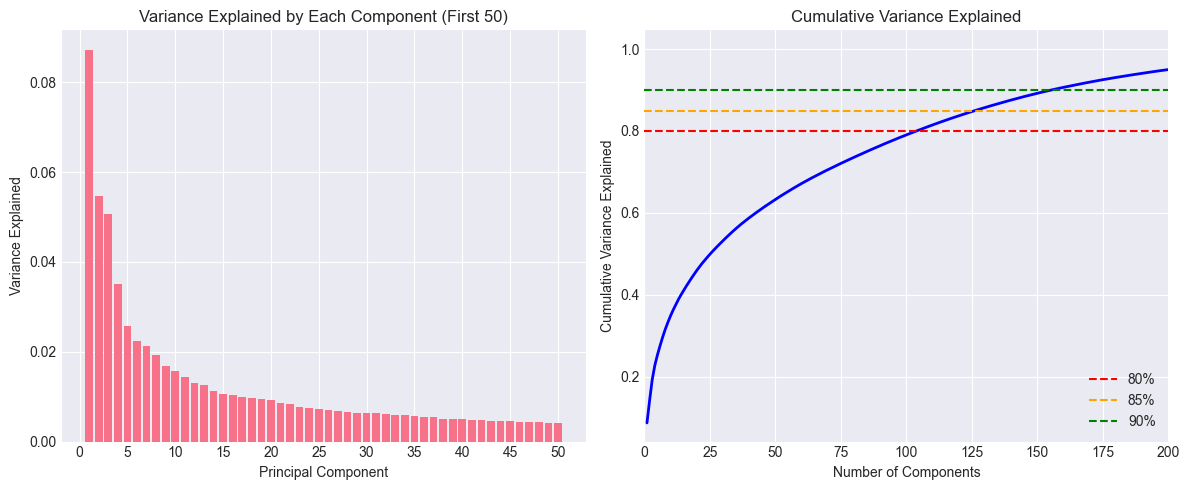


✅ Selected 127 components (explains 85% variance)

Applying PCA with 127 components...
✅ AZDIAS PCA: (791234, 127)
✅ CUSTOMERS PCA: (140863, 127)
📊 Reduced from 319 to 127 features!


In [13]:
print("\n" + "="*70)
print("3. DIMENSIONALITY REDUCTION (PCA)")
print("="*70)

# First, let's see how many components we need to explain 80-90% variance

print("Finding optimal number of PCA components...")

# Fit PCA with all components to see variance explained
pca_full = PCA()
pca_full.fit(azdias_scaled)

# Calculate cumulative variance
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 80%, 85%, 90% variance
n_components_80 = np.argmax(cumsum_variance >= 0.80) + 1
n_components_85 = np.argmax(cumsum_variance >= 0.85) + 1
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f"\nComponents needed to explain variance:")
print(f"  80% variance: {n_components_80} components")
print(f"  85% variance: {n_components_85} components")
print(f"  90% variance: {n_components_90} components")

# Plot variance explained
plt.figure(figsize=(12, 5))

# Plot 1: Individual variance
plt.subplot(1, 2, 1)
plt.bar(range(1, 51), pca_full.explained_variance_ratio_[:50])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Component (First 50)')
plt.xticks(range(0, 51, 5))

# Plot 2: Cumulative variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumsum_variance)+1), cumsum_variance, 'b-', linewidth=2)
plt.axhline(y=0.80, color='r', linestyle='--', label='80%')
plt.axhline(y=0.85, color='orange', linestyle='--', label='85%')
plt.axhline(y=0.90, color='g', linestyle='--', label='90%')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.xlim(0, 200)
plt.grid(True)

plt.tight_layout()
plt.savefig('pca_variance_analysis.png', dpi=150, bbox_inches='tight')
print("\n✅ Plot saved: pca_variance_analysis.png")
plt.show()

# Choose number of components (let's use 85% variance as a balance)
n_components = n_components_85
print(f"\n✅ Selected {n_components} components (explains 85% variance)")

# Apply PCA with selected number of components
print(f"\nApplying PCA with {n_components} components...")
pca = PCA(n_components=n_components)

# Transform both datasets
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)

print(f"✅ AZDIAS PCA: {azdias_pca.shape}")
print(f"✅ CUSTOMERS PCA: {customers_pca.shape}")
print(f"📊 Reduced from {azdias_scaled.shape[1]} to {n_components} features!")

## Step 4: Find Optimal Number of Clusters (Elbow Method)


4. FINDING OPTIMAL NUMBER OF CLUSTERS
Testing K from 2 to 20...
(This may take a few minutes...)

Testing K=2... Inertia: 25141105, Silhouette: 0.073
Testing K=3... Inertia: 24379967, Silhouette: 0.047
Testing K=4... Inertia: 23762921, Silhouette: 0.044
Testing K=5... Inertia: 23276874, Silhouette: 0.038
Testing K=6... Inertia: 22852963, Silhouette: 0.037
Testing K=7... Inertia: 22515735, Silhouette: 0.036
Testing K=8... Inertia: 22285006, Silhouette: 0.035
Testing K=9... Inertia: 22072761, Silhouette: 0.033
Testing K=10... Inertia: 21931316, Silhouette: 0.029
Testing K=11... Inertia: 21749287, Silhouette: 0.028
Testing K=12... Inertia: 21634906, Silhouette: 0.026
Testing K=13... Inertia: 21523392, Silhouette: 0.026
Testing K=14... Inertia: 21439730, Silhouette: 0.023
Testing K=15... Inertia: 21316523, Silhouette: 0.023
Testing K=16... Inertia: 21193885
Testing K=17... Inertia: 21103168
Testing K=18... Inertia: 21057825
Testing K=19... Inertia: 20945105
Testing K=20... Inertia: 209116

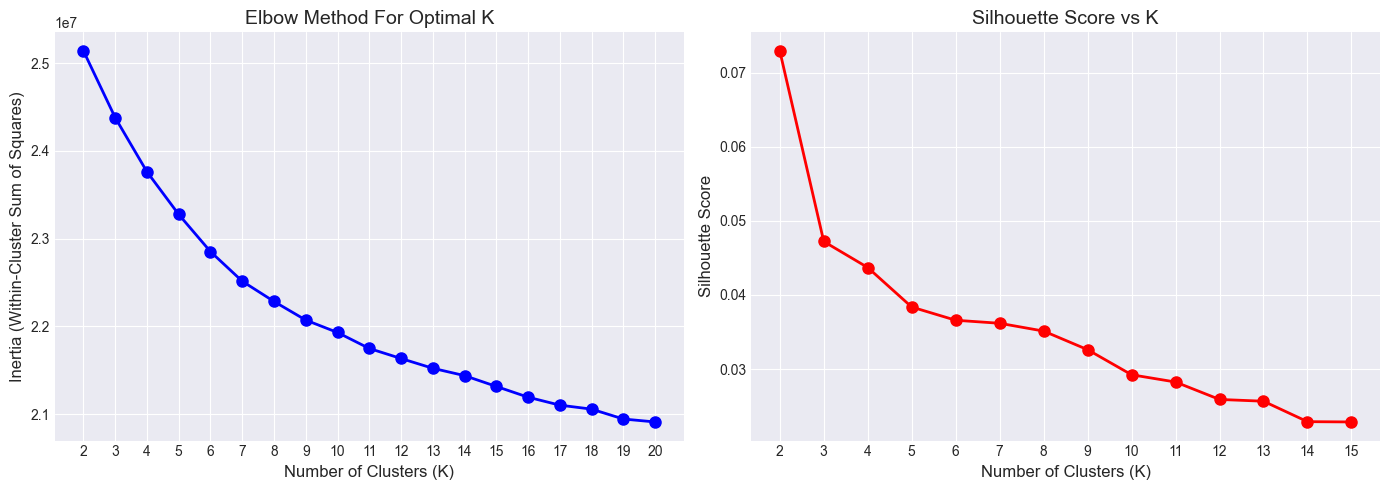


RECOMMENDATION:
Look at the elbow plot:
  - Find the 'elbow' where inertia stops decreasing rapidly
  - Common choices: K=8 to K=15 for this type of data
  - Higher silhouette score = better separation

✅ You selected K=14


In [14]:
print("\n" + "="*70)
print("4. FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

# Test different numbers of clusters
K_range = range(2, 21)
inertias = []
silhouette_scores = []

print("Testing K from 2 to 20...")
print("(This may take a few minutes...)\n")

for k in K_range:
    print(f"Testing K={k}...", end=' ')
    
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    
    # Use a sample for speed (100k rows)
    sample_size = min(100000, len(azdias_pca))
    sample_indices = np.random.choice(len(azdias_pca), sample_size, replace=False)
    
    kmeans.fit(azdias_pca[sample_indices])
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    
    # Silhouette score (use smaller sample for speed)
    if k <= 15:  # Only calculate for smaller K (it's expensive)
        silhouette_sample = min(10000, sample_size)
        silhouette_indices = np.random.choice(sample_size, silhouette_sample, replace=False)
        score = silhouette_score(
            azdias_pca[sample_indices][silhouette_indices], 
            kmeans.predict(azdias_pca[sample_indices][silhouette_indices])
        )
        silhouette_scores.append(score)
        print(f"Inertia: {kmeans.inertia_:.0f}, Silhouette: {score:.3f}")
    else:
        silhouette_scores.append(None)
        print(f"Inertia: {kmeans.inertia_:.0f}")

# Plot elbow curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method For Optimal K', fontsize=14)
plt.grid(True)
plt.xticks(K_range)

plt.subplot(1, 2, 2)
valid_silhouettes = [(k, s) for k, s in zip(K_range, silhouette_scores) if s is not None]
if valid_silhouettes:
    ks, scores = zip(*valid_silhouettes)
    plt.plot(ks, scores, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Score vs K', fontsize=14)
    plt.grid(True)
    plt.xticks(ks)

plt.tight_layout()
plt.savefig('kmeans_optimal_k.png', dpi=150, bbox_inches='tight')
print("\n✅ Plot saved: kmeans_optimal_k.png")
plt.show()

# Suggest optimal K
print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)
print("Look at the elbow plot:")
print("  - Find the 'elbow' where inertia stops decreasing rapidly")
print("  - Common choices: K=8 to K=15 for this type of data")
print("  - Higher silhouette score = better separation")

optimal_k = int(input("\nEnter your chosen K (e.g., 10): "))
print(f"\n✅ You selected K={optimal_k}")

## Step 5: Fit Final K-Means Model

In [15]:
print("\n" + "="*70)
print(f"5. FITTING K-MEANS WITH K={optimal_k}")
print("="*70)

print("Training final K-means model...")
print("(This may take a few minutes for large dataset...)")

kmeans_final = KMeans(
    n_clusters=optimal_k, 
    random_state=42, 
    n_init=20,  # More initializations for better result
    max_iter=300,
    verbose=1
)

# Fit on AZDIAS (general population)
print("\nFitting on AZDIAS...")
azdias_clusters = kmeans_final.fit_predict(azdias_pca)
print(f"✅ AZDIAS clustered!")

# Predict on CUSTOMERS
print("Predicting clusters for CUSTOMERS...")
customers_clusters = kmeans_final.predict(customers_pca)
print(f"✅ CUSTOMERS clustered!")

# Add cluster labels to original dataframes
azdias['Cluster'] = azdias_clusters
customers['Cluster'] = customers_clusters

print(f"\n📊 Clustering complete with {optimal_k} clusters!")


5. FITTING K-MEANS WITH K=14
Training final K-means model...
(This may take a few minutes for large dataset...)

Fitting on AZDIAS...
Initialization complete
Iteration 0, inertia 272607723.66285324.
Iteration 1, inertia 177486871.50722688.
Iteration 2, inertia 173727757.57252514.
Iteration 3, inertia 172457209.322106.
Iteration 4, inertia 171768819.89451438.
Iteration 5, inertia 171293021.8004538.
Iteration 6, inertia 170996246.72857875.
Iteration 7, inertia 170829833.8135834.
Iteration 8, inertia 170732948.1193225.
Iteration 9, inertia 170666606.55166054.
Iteration 10, inertia 170609582.3282411.
Iteration 11, inertia 170549433.66455585.
Iteration 12, inertia 170483706.18786478.
Iteration 13, inertia 170417452.93772855.
Iteration 14, inertia 170354934.4773123.
Iteration 15, inertia 170298477.78321284.
Iteration 16, inertia 170249780.83901834.
Iteration 17, inertia 170208476.91759127.
Iteration 18, inertia 170173913.20483166.
Iteration 19, inertia 170145563.90035444.
Iteration 20, iner

## Step 6: Compare Cluster Distributions
This is where the magic happens - finding which clusters are customer-heavy!


6. CLUSTER COMPARISON: CUSTOMERS vs GENERAL POPULATION

📊 CLUSTER COMPARISON TABLE:
    General_Population_%  Customers_%  Difference_%  Ratio
0                   9.47        34.53         25.06   3.65
7                   5.99        13.25          7.26   2.21
13                  5.72        11.95          6.23   2.09
4                   8.83        10.76          1.93   1.22
5                  10.92        10.70         -0.22   0.98
1                   5.30         3.89         -1.41   0.73
9                   8.56         5.23         -3.33   0.61
11                  4.34         2.51         -1.83   0.58
3                   5.86         2.16         -3.70   0.37
10                  5.39         1.93         -3.46   0.36
6                   6.53         1.74         -4.79   0.27
2                   4.04         0.25         -3.79   0.06
8                  11.07         0.69        -10.38   0.06
12                  7.98         0.42         -7.56   0.05

Interpretation:
  Ratio > 1.0

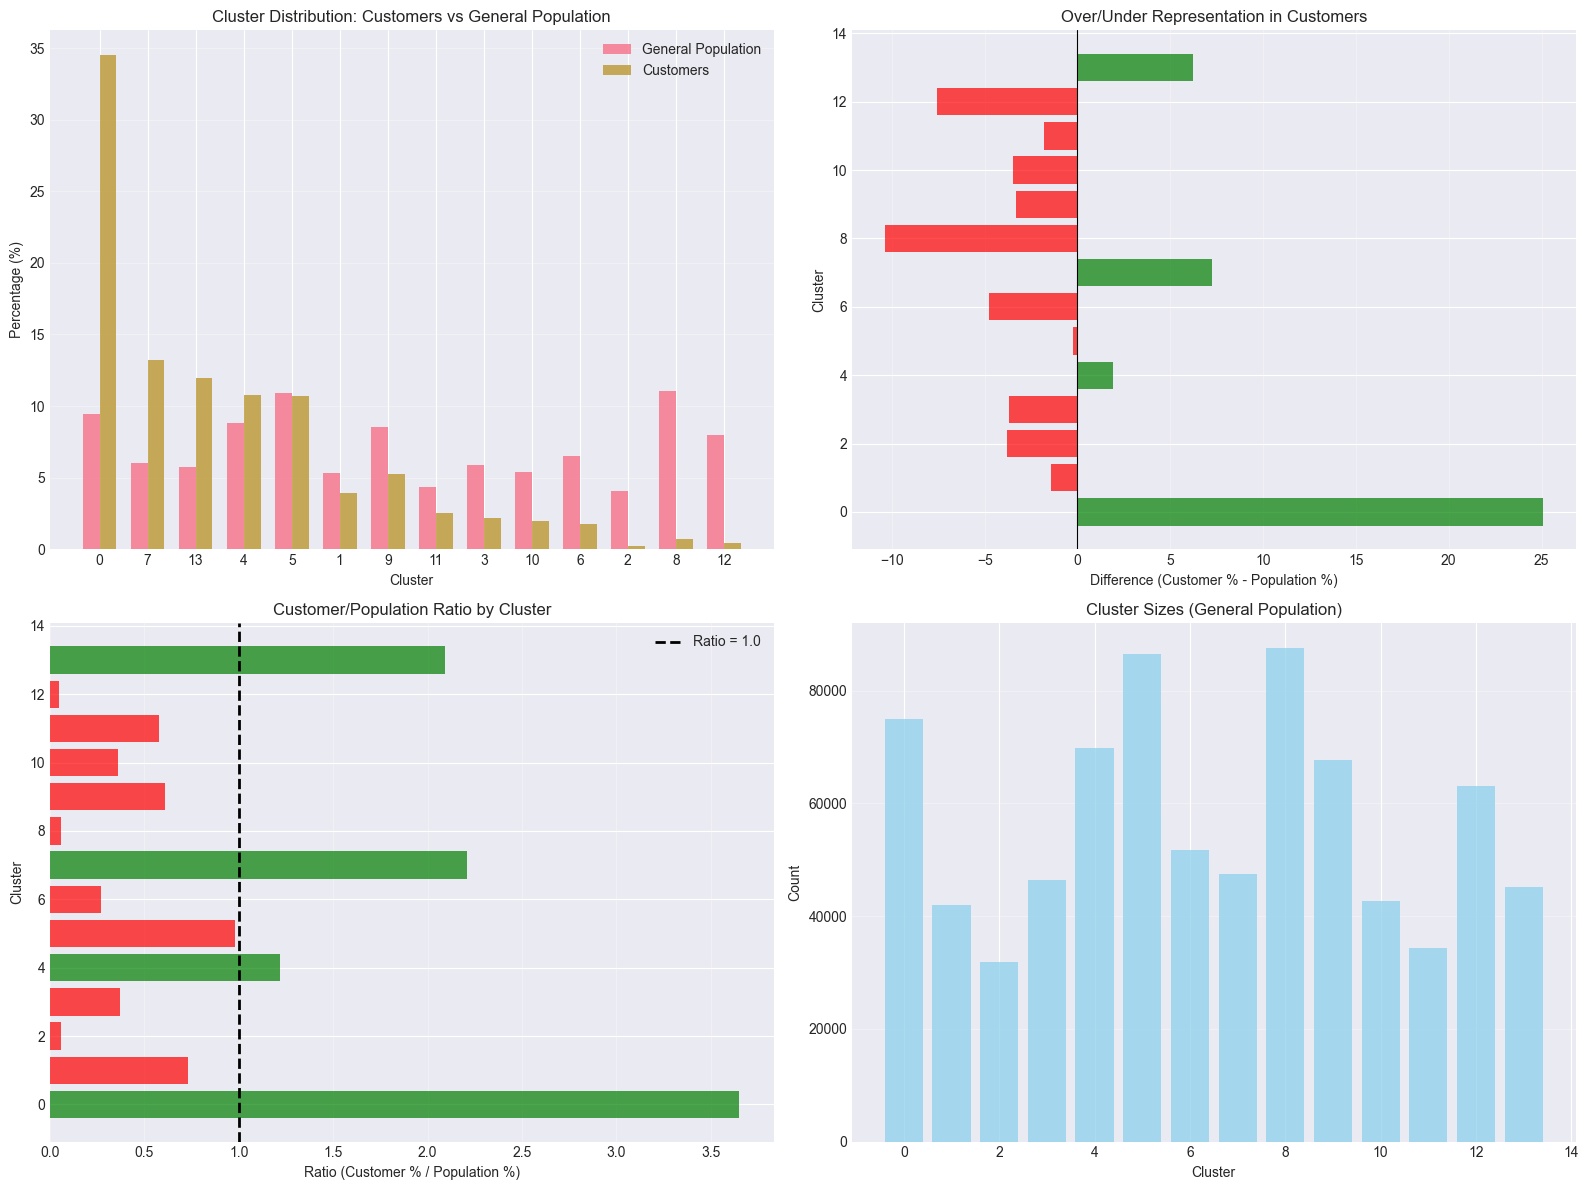

In [16]:
print("\n" + "="*70)
print("6. CLUSTER COMPARISON: CUSTOMERS vs GENERAL POPULATION")
print("="*70)

# Calculate cluster distributions
azdias_cluster_dist = pd.Series(azdias_clusters).value_counts(normalize=True).sort_index()
customers_cluster_dist = pd.Series(customers_clusters).value_counts(normalize=True).sort_index()

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'General_Population_%': (azdias_cluster_dist * 100).round(2),
    'Customers_%': (customers_cluster_dist * 100).round(2)
})

# Calculate over/under representation
comparison_df['Difference_%'] = (
    comparison_df['Customers_%'] - comparison_df['General_Population_%']
).round(2)

comparison_df['Ratio'] = (
    comparison_df['Customers_%'] / comparison_df['General_Population_%']
).round(2)

# Sort by ratio (most over-represented first)
comparison_df = comparison_df.sort_values('Ratio', ascending=False)

print("\n📊 CLUSTER COMPARISON TABLE:")
print("="*70)
print(comparison_df)
print("\nInterpretation:")
print("  Ratio > 1.0: Over-represented in customers (GOOD TARGET)")
print("  Ratio < 1.0: Under-represented in customers (POOR TARGET)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Side-by-side bar chart
ax1 = axes[0, 0]
x = np.arange(optimal_k)
width = 0.35
ax1.bar(x - width/2, comparison_df['General_Population_%'], width, label='General Population', alpha=0.8)
ax1.bar(x + width/2, comparison_df['Customers_%'], width, label='Customers', alpha=0.8)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Cluster Distribution: Customers vs General Population')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df.index)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Difference chart
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in comparison_df['Difference_%']]
ax2.barh(comparison_df.index, comparison_df['Difference_%'], color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Difference (Customer % - Population %)')
ax2.set_ylabel('Cluster')
ax2.set_title('Over/Under Representation in Customers')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Ratio chart
ax3 = axes[1, 0]
colors = ['green' if x > 1 else 'red' for x in comparison_df['Ratio']]
ax3.barh(comparison_df.index, comparison_df['Ratio'], color=colors, alpha=0.7)
ax3.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Ratio = 1.0')
ax3.set_xlabel('Ratio (Customer % / Population %)')
ax3.set_ylabel('Cluster')
ax3.set_title('Customer/Population Ratio by Cluster')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Cluster sizes
ax4 = axes[1, 1]
cluster_sizes = pd.Series(azdias_clusters).value_counts().sort_index()
ax4.bar(cluster_sizes.index, cluster_sizes.values, alpha=0.7, color='skyblue')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Count')
ax4.set_title('Cluster Sizes (General Population)')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_comparison_analysis.png', dpi=150, bbox_inches='tight')
print("\n✅ Plot saved: cluster_comparison_analysis.png")
plt.show()

## Step 7: Interpret Top Clusters

In [17]:
print("\n" + "="*70)
print("7. CLUSTER INTERPRETATION")
print("="*70)

# Identify top and bottom clusters
top_clusters = comparison_df.head(3).index.tolist()
bottom_clusters = comparison_df.tail(3).index.tolist()

print(f"\n🎯 TOP 3 CLUSTERS (Over-represented in customers):")
print(f"   Clusters: {top_clusters}")
print(f"   These are your PRIMARY TARGET segments!")

print(f"\n❌ BOTTOM 3 CLUSTERS (Under-represented in customers):")
print(f"   Clusters: {bottom_clusters}")
print(f"   Avoid marketing to these segments!")

# For each top cluster, show some characteristics
print("\n" + "="*70)
print("CLUSTER CHARACTERISTICS (Top 3 Clusters)")
print("="*70)

for cluster_id in top_clusters:
    print(f"\n📊 CLUSTER {cluster_id} (Ratio: {comparison_df.loc[cluster_id, 'Ratio']:.2f}x)")
    print("-" * 50)
    
    # Get people in this cluster
    cluster_mask = azdias['Cluster'] == cluster_id
    cluster_data = azdias[cluster_mask]
    
    # Show mean values for first 10 features (as example)
    print("Average characteristics (first 10 features):")
    feature_means = cluster_data.iloc[:, :10].mean()
    print(feature_means.round(2))
    
    print(f"\nSize: {len(cluster_data):,} people ({len(cluster_data)/len(azdias)*100:.1f}% of population)")

print("\n" + "="*70)
print("💡 NEXT STEPS:")
print("="*70)
print("1. ✅ You've identified which clusters are customer-like")
print("2. ✅ You know which segments to target (high ratio)")
print("3. ✅ You know which segments to avoid (low ratio)")
print("4. 🔜 In Part 2, you'll use this to predict campaign responses!")


7. CLUSTER INTERPRETATION

🎯 TOP 3 CLUSTERS (Over-represented in customers):
   Clusters: [0, 7, 13]
   These are your PRIMARY TARGET segments!

❌ BOTTOM 3 CLUSTERS (Under-represented in customers):
   Clusters: [2, 8, 12]
   Avoid marketing to these segments!

CLUSTER CHARACTERISTICS (Top 3 Clusters)

📊 CLUSTER 0 (Ratio: 3.65x)
--------------------------------------------------
Average characteristics (first 10 features):
KBA13_VORB_1_2          2.86
D19_BUCH_CD             5.88
PLZ8_BAUMAX             1.11
KBA05_SEG8              0.96
RT_UEBERGROESSE         2.52
KBA13_KW_70             2.32
CAMEO_DEUG_2015         3.73
KBA05_SEG10             2.26
KBA13_ALTERHALTER_30    2.62
ANZ_TITEL               0.01
dtype: float64

Size: 74,964 people (9.5% of population)

📊 CLUSTER 7 (Ratio: 2.21x)
--------------------------------------------------
Average characteristics (first 10 features):
KBA13_VORB_1_2          2.97
D19_BUCH_CD             4.26
PLZ8_BAUMAX             1.08
KBA05_SEG8    

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### STEP 1: Load MAILOUT_TRAIN data

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PART 2: SUPERVISED LEARNING MODEL")
print("="*70)

# ============================================================================
# STEP 1: Load MAILOUT_TRAIN data
# ============================================================================
print("\n📂 STEP 1: Loading MAILOUT_TRAIN data...")

mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
print(f"✅ MAILOUT_TRAIN loaded: {mailout_train.shape}")

# Check response distribution
print("\n📊 Response Distribution:")
response_counts = mailout_train['RESPONSE'].value_counts()
print(response_counts)
print(f"\nResponse rate: {response_counts[1] / len(mailout_train) * 100:.2f}%")

# Separate features and target
y_train = mailout_train['RESPONSE']
X_train_raw = mailout_train.drop('RESPONSE', axis=1)

print(f"\n✅ X_train: {X_train_raw.shape}")
print(f"✅ y_train: {y_train.shape}")


PART 2: SUPERVISED LEARNING MODEL

📂 STEP 1: Loading MAILOUT_TRAIN data...
✅ MAILOUT_TRAIN loaded: (42962, 367)

📊 Response Distribution:
RESPONSE
0    42430
1      532
Name: count, dtype: int64

Response rate: 1.24%

✅ X_train: (42962, 366)
✅ y_train: (42962,)


###  Preprocess MAILOUT_TRAIN (same as Part 1)

In [21]:
# ============================================================================
# STEP 2: Preprocess MAILOUT_TRAIN (same as Part 1)
# ============================================================================
print("\n🧹 STEP 2: Preprocessing MAILOUT_TRAIN...")

# Reuse cleaning function from Part 1
print("Applying cleaning transformations...")
X_train_clean = clean_demographics_data(X_train_raw)

# Align columns with what we used in Part 1
# Load one of the cleaned datasets to get column names
azdias_reference = pd.read_csv('data/azdias_cleaned.csv', nrows=1)
expected_cols = azdias_reference.columns.tolist()

print(f"Expected columns from Part 1: {len(expected_cols)}")
print(f"Current columns: {len(X_train_clean.columns)}")

# Keep only columns that exist in both
common_cols = [col for col in expected_cols if col in X_train_clean.columns]
X_train_clean = X_train_clean[common_cols]

print(f"✅ Aligned to {len(common_cols)} common features")

# Handle any remaining missing values (use median imputation)
from sklearn.impute import SimpleImputer

print("Imputing any remaining missing values...")
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_clean),
    columns=X_train_clean.columns,
    index=X_train_clean.index
)

print(f"✅ MAILOUT_TRAIN preprocessed: {X_train_imputed.shape}")



🧹 STEP 2: Preprocessing MAILOUT_TRAIN...
Applying cleaning transformations...
  → Converting -1 to NaN...
  → Converting specific 0 values to NaN...
  → Converting D19 transaction 0's to NaN...
  → Converting 9 to NaN for specific columns...
  → Fixing CAMEO columns...
  → Converting 'D19_UNBEKANNT' to NaN...
  → Dropping date/time columns...
  ✓ Shape after cleaning: (42962, 365)
Expected columns from Part 1: 319
Current columns: 365
✅ Aligned to 319 common features
Imputing any remaining missing values...
✅ MAILOUT_TRAIN preprocessed: (42962, 319)


### STEP 3: Apply Part 1 Transformations (PCA, Clustering)

In [22]:
# ============================================================================
# STEP 3: Apply Part 1 Transformations (PCA, Clustering)
# ============================================================================
print("\n🔄 STEP 3: Applying Part 1 transformations...")

# We need to load the fitted scaler, PCA, and KMeans from Part 1
# Option 1: If you saved them
# scaler = joblib.load('models/scaler.pkl')
# pca = joblib.load('models/pca.pkl')
# kmeans = joblib.load('models/kmeans.pkl')

# Option 2: Re-fit them (if you didn't save)
print("Re-loading and fitting transformations from AZDIAS...")

# Load cleaned AZDIAS
azdias = pd.read_pickle('data/azdias_cleaned.pkl')  # Faster than CSV

# Fit scaler
print("  → Fitting scaler...")
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)

# Fit PCA (use same number of components as Part 1)
n_components = 85  # Adjust based on what you used in Part 1
print(f"  → Fitting PCA with {n_components} components...")
pca = PCA(n_components=n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

# Fit KMeans (use same K as Part 1)
optimal_k = 14  # Adjust based on what you chose in Part 1
print(f"  → Fitting KMeans with K={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans.fit(azdias_pca)

print("✅ Transformations fitted on AZDIAS")

# Now transform MAILOUT_TRAIN
print("\nTransforming MAILOUT_TRAIN...")
X_train_scaled = scaler.transform(X_train_imputed)
X_train_pca = pca.transform(X_train_scaled)
X_train_clusters = kmeans.predict(X_train_pca)

print(f"✅ Scaled: {X_train_scaled.shape}")
print(f"✅ PCA: {X_train_pca.shape}")
print(f"✅ Clusters assigned")




🔄 STEP 3: Applying Part 1 transformations...
Re-loading and fitting transformations from AZDIAS...
  → Fitting scaler...
  → Fitting PCA with 85 components...
  → Fitting KMeans with K=14...
✅ Transformations fitted on AZDIAS

Transforming MAILOUT_TRAIN...
✅ Scaled: (42962, 319)
✅ PCA: (42962, 85)
✅ Clusters assigned


### STEP 4: Feature Engineering (Using Part 1 Insights!)

In [23]:
# ============================================================================
# STEP 4: Feature Engineering (Using Part 1 Insights!)
# ============================================================================
print("\n🛠️  STEP 4: Feature Engineering...")

# Create DataFrame with PCA components
X_train_features = pd.DataFrame(
    X_train_pca,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_train_imputed.index
)

# Add cluster membership as features
X_train_features['Cluster'] = X_train_clusters

# Create binary features for high-value clusters (from Part 1)
high_value_clusters = [0, 7, 13]  # Your top 3 clusters!
low_value_clusters = [2, 8, 12]   # Your bottom 3 clusters

X_train_features['is_high_value_cluster'] = X_train_features['Cluster'].isin(high_value_clusters).astype(int)
X_train_features['is_low_value_cluster'] = X_train_features['Cluster'].isin(low_value_clusters).astype(int)

# One-hot encode cluster membership
cluster_dummies = pd.get_dummies(X_train_features['Cluster'], prefix='Cluster')
X_train_features = pd.concat([X_train_features, cluster_dummies], axis=1)

print(f"✅ Feature engineering complete: {X_train_features.shape}")
print(f"\nFeatures created:")
print(f"  • {n_components} PCA components")
print(f"  • Cluster assignment")
print(f"  • High/low value cluster flags")
print(f"  • {optimal_k} cluster dummy variables")


🛠️  STEP 4: Feature Engineering...
✅ Feature engineering complete: (42962, 102)

Features created:
  • 85 PCA components
  • Cluster assignment
  • High/low value cluster flags
  • 14 cluster dummy variables


### STEP 5: Handle Class Imbalance

In [24]:
# ============================================================================
# STEP 5: Handle Class Imbalance
# ============================================================================
print("\n⚖️  STEP 5: Handling class imbalance...")

print(f"Original class distribution:")
print(y_train.value_counts())
print(f"Imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.1f}:1")

# Strategy: Combine SMOTE (oversampling minority) with undersampling majority
print("\nApplying SMOTE + RandomUnderSampler...")

# Define resampling strategy
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Oversample to 30% ratio
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Undersample to 50% ratio

# Apply resampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())
print(f"New ratio: {pd.Series(y_train_resampled).value_counts()[0] / pd.Series(y_train_resampled).value_counts()[1]:.1f}:1")


⚖️  STEP 5: Handling class imbalance...
Original class distribution:
RESPONSE
0    42430
1      532
Name: count, dtype: int64
Imbalance ratio: 79.8:1

Applying SMOTE + RandomUnderSampler...

Resampled class distribution:
RESPONSE
0    25458
1    12729
Name: count, dtype: int64
New ratio: 2.0:1


### STEP 6: Train Classification Models

In [25]:
# ============================================================================
# STEP 6: Train Classification Models
# ============================================================================
print("\n🤖 STEP 6: Training classification models...")

# Split resampled data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled,
    test_size=0.2, random_state=42, stratify=y_train_resampled
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val_split.shape}")

# Define models to try
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        learning_rate=0.1
    )
}

results = {}

print("\nTraining and evaluating models...")
print("-" * 70)

for name, model in models.items():
    print(f"\n🔹 {name}")
    
    # Train
    print("  Training...", end=' ')
    model.fit(X_train_split, y_train_split)
    print("✓")
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_val_split)[:, 1]
    
    # Calculate ROC-AUC (main metric for imbalanced data)
    roc_auc = roc_auc_score(y_val_split, y_pred_proba)
    
    # Predict classes (threshold = 0.5)
    y_pred = model.predict(X_val_split)
    
    results[name] = {
        'model': model,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  ROC-AUC Score: {roc_auc:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_val_split, y_pred, target_names=['No Response', 'Response']))



🤖 STEP 6: Training classification models...
Training set: (30549, 102)
Validation set: (7638, 102)

Training and evaluating models...
----------------------------------------------------------------------

🔹 Logistic Regression
  Training... ✓
  ROC-AUC Score: 0.7794

  Classification Report:
              precision    recall  f1-score   support

 No Response       0.80      0.79      0.80      5092
    Response       0.59      0.60      0.59      2546

    accuracy                           0.73      7638
   macro avg       0.69      0.70      0.69      7638
weighted avg       0.73      0.73      0.73      7638


🔹 Random Forest
  Training... ✓
  ROC-AUC Score: 0.9544

  Classification Report:
              precision    recall  f1-score   support

 No Response       0.96      0.90      0.93      5092
    Response       0.83      0.93      0.88      2546

    accuracy                           0.91      7638
   macro avg       0.89      0.92      0.90      7638
weighted avg       0.92

### STEP 7: Select Best Model and Visualize


🏆 STEP 7: Model Selection...

🎯 Best Model: Gradient Boosting
   ROC-AUC: 0.9709

✅ Plots saved: model_evaluation.png


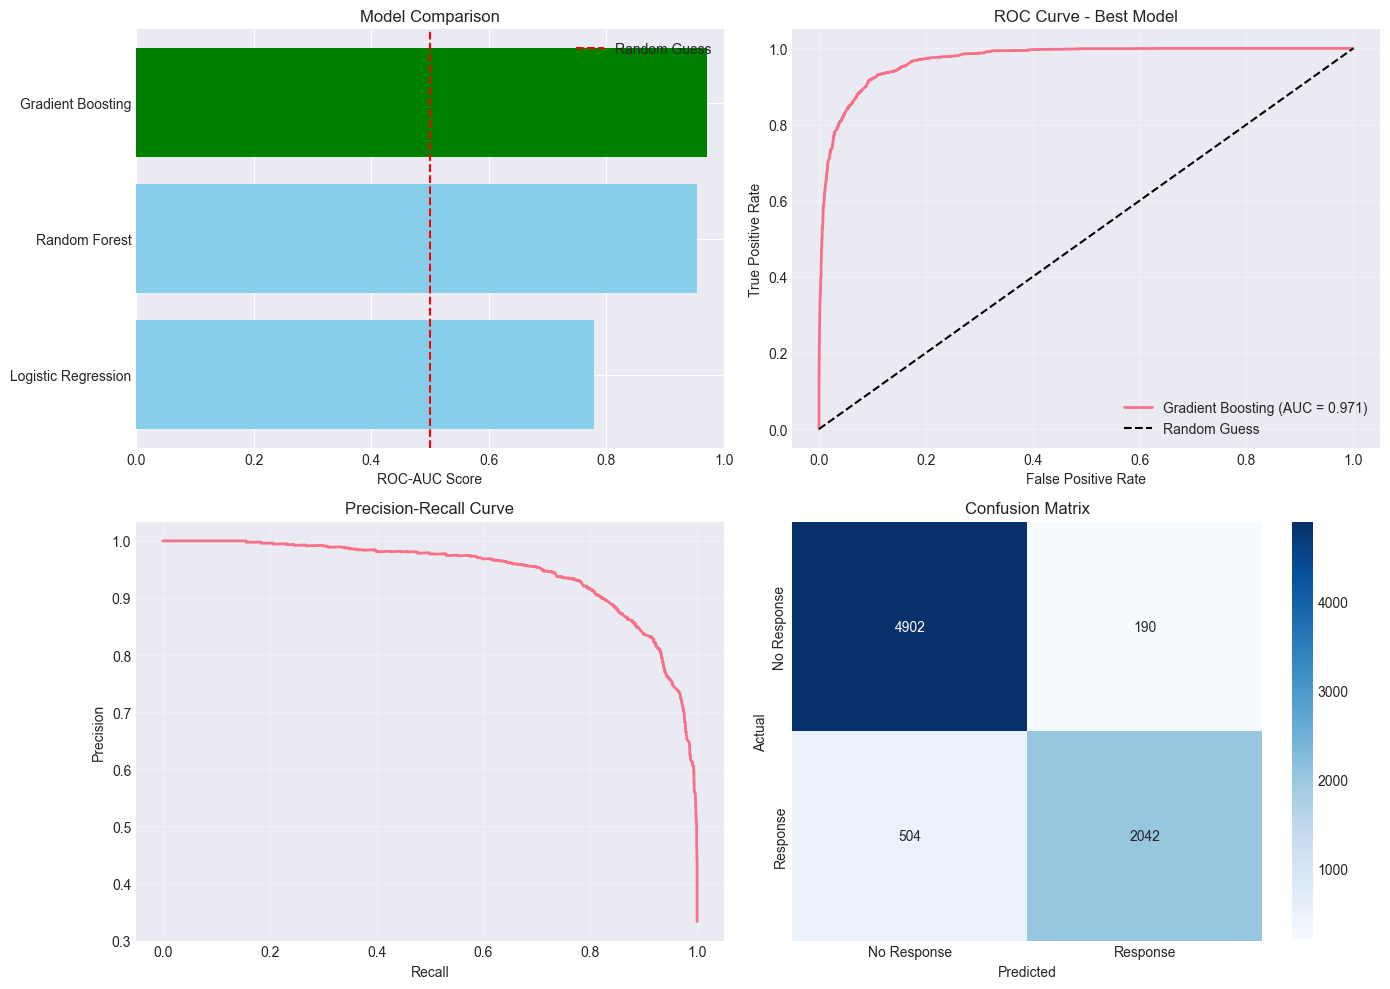

In [26]:
# ============================================================================
# STEP 7: Select Best Model and Visualize
# ============================================================================
print("\n🏆 STEP 7: Model Selection...")

# Find best model by ROC-AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']
best_roc_auc = results[best_model_name]['roc_auc']

print(f"\n🎯 Best Model: {best_model_name}")
print(f"   ROC-AUC: {best_roc_auc:.4f}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: ROC-AUC Comparison
ax1 = axes[0, 0]
model_names = list(results.keys())
roc_scores = [results[m]['roc_auc'] for m in model_names]
colors = ['green' if m == best_model_name else 'skyblue' for m in model_names]
ax1.barh(model_names, roc_scores, color=colors)
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('Model Comparison')
ax1.axvline(x=0.5, color='red', linestyle='--', label='Random Guess')
ax1.legend()
ax1.set_xlim(0, 1)

# Plot 2: ROC Curve for best model
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_val_split, results[best_model_name]['probabilities'])
ax2.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC = {best_roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Best Model')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = axes[1, 0]
precision, recall, _ = precision_recall_curve(y_val_split, results[best_model_name]['probabilities'])
ax3.plot(recall, precision, linewidth=2)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve')
ax3.grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
ax4 = axes[1, 1]
cm = confusion_matrix(y_val_split, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title('Confusion Matrix')
ax4.set_xticklabels(['No Response', 'Response'])
ax4.set_yticklabels(['No Response', 'Response'])

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=150, bbox_inches='tight')
print("\n✅ Plots saved: model_evaluation.png")
plt.show()


### STEP 8: Feature Importance (if applicable)


📊 STEP 8: Feature Importance...

Top 20 Most Important Features:
        feature  importance
99   Cluster_11    0.067606
85      Cluster    0.047731
101  Cluster_13    0.043512
63         PC64    0.030585
43         PC44    0.027614
30         PC31    0.024647
1           PC2    0.022799
41         PC42    0.020017
66         PC67    0.019768
3           PC4    0.017973
52         PC53    0.016793
44         PC45    0.015895
19         PC20    0.015895
14         PC15    0.015490
91    Cluster_3    0.015406
29         PC30    0.015225
81         PC82    0.014779
16         PC17    0.014476
6           PC7    0.013614
17         PC18    0.013377
✅ Plot saved: feature_importance.png


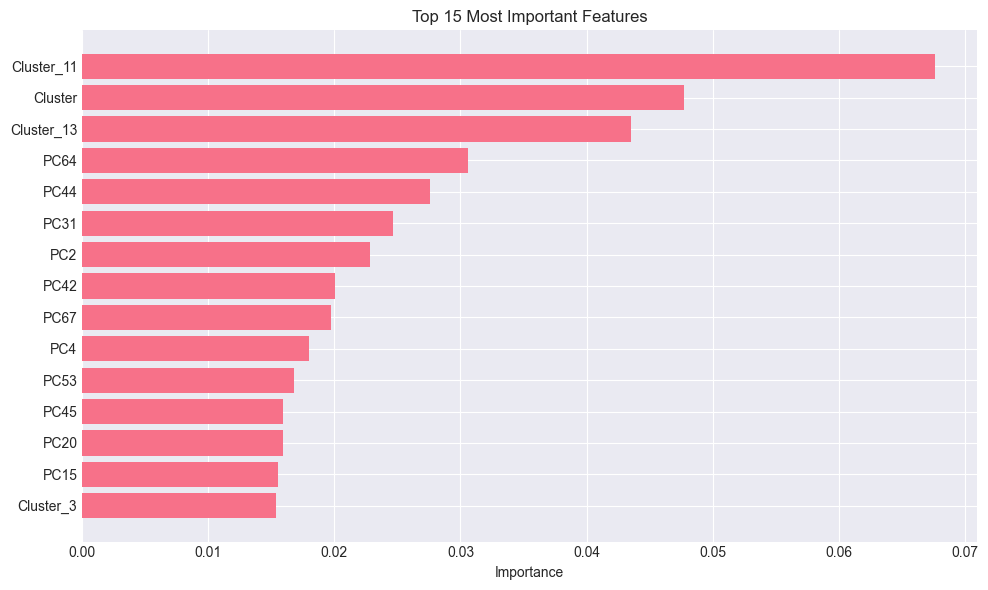


💡 PART 2 SUMMARY
✅ Preprocessed MAILOUT_TRAIN data
✅ Applied Part 1 transformations (PCA, clustering)
✅ Engineered features using cluster insights
✅ Handled class imbalance with SMOTE + undersampling
✅ Trained and compared 3 models
✅ Best model: Gradient Boosting (ROC-AUC: 0.9709)

🔜 NEXT: Apply this model to MAILOUT_TEST for Kaggle submission!


In [27]:
# ============================================================================
# STEP 8: Feature Importance (if applicable)
# ============================================================================
if hasattr(best_model, 'feature_importances_'):
    print("\n📊 STEP 8: Feature Importance...")
    
    feature_importance = pd.DataFrame({
        'feature': X_train_features.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))
    
    # Plot top 15 features
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved: feature_importance.png")
    plt.show()

print("\n" + "="*70)
print("💡 PART 2 SUMMARY")
print("="*70)
print(f"✅ Preprocessed MAILOUT_TRAIN data")
print(f"✅ Applied Part 1 transformations (PCA, clustering)")
print(f"✅ Engineered features using cluster insights")
print(f"✅ Handled class imbalance with SMOTE + undersampling")
print(f"✅ Trained and compared {len(models)} models")
print(f"✅ Best model: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")
print(f"\n🔜 NEXT: Apply this model to MAILOUT_TEST for Kaggle submission!")

# 🚀 Part 3: Kaggle Submission (Final Step!)
Now let's make predictions on MAILOUT_TEST and create   Kaggle submission:

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PART 3: KAGGLE SUBMISSION - PREDICTIONS ON MAILOUT_TEST")
print("="*70)

# ============================================================================
# STEP 1: Load MAILOUT_TEST
# ============================================================================
print("\n📂 STEP 1: Loading MAILOUT_TEST...")

mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
print(f"✅ MAILOUT_TEST loaded: {mailout_test.shape}")

# Save the LNR column (IDs) for submission
test_ids = mailout_test['LNR'] if 'LNR' in mailout_test.columns else mailout_test.index

# Remove ID column if exists
if 'LNR' in mailout_test.columns:
    X_test_raw = mailout_test.drop('LNR', axis=1)
else:
    X_test_raw = mailout_test.copy()

print(f"✅ Test features: {X_test_raw.shape}")
print(f"✅ Test IDs saved: {len(test_ids)}")

# ============================================================================
# STEP 2: Preprocess MAILOUT_TEST (exact same as MAILOUT_TRAIN)
# ============================================================================
print("\n🧹 STEP 2: Preprocessing MAILOUT_TEST...")

 

print("Cleaning test data...")
X_test_clean = clean_demographics_data(X_test_raw)

# Align with training columns
azdias_reference = pd.read_csv('data/azdias_cleaned.csv', nrows=1)
expected_cols = azdias_reference.columns.tolist()

common_cols = [col for col in expected_cols if col in X_test_clean.columns]
X_test_clean = X_test_clean[common_cols]

print(f"✅ Aligned to {len(common_cols)} features")

# Impute missing values
print("Imputing missing values...")
imputer = SimpleImputer(strategy='median')
X_test_imputed = pd.DataFrame(
    imputer.fit_transform(X_test_clean),
    columns=X_test_clean.columns,
    index=X_test_clean.index
)

print(f"✅ Test data preprocessed: {X_test_imputed.shape}")

# ============================================================================
# STEP 3: Apply Transformations (Scaler, PCA, KMeans)
# ============================================================================
print("\n🔄 STEP 3: Applying transformations...")

# Load AZDIAS to fit transformations (same as Part 2)
print("Loading AZDIAS for transformations...")
azdias = pd.read_pickle('data/azdias_cleaned.pkl')

# Fit scaler
print("  → Fitting scaler...")
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)

# Fit PCA (use same n_components as Part 2)
n_components = 85  # Must match Part 2!
print(f"  → Fitting PCA with {n_components} components...")
pca = PCA(n_components=n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

# Fit KMeans (use same K as Part 2)
optimal_k = 14  # Must match Part 2!
print(f"  → Fitting KMeans with K={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans.fit(azdias_pca)

# Transform test data
print("\nTransforming test data...")
X_test_scaled = scaler.transform(X_test_imputed)
X_test_pca = pca.transform(X_test_scaled)
X_test_clusters = kmeans.predict(X_test_pca)

print(f"✅ Test data transformed: {X_test_pca.shape}")

# ============================================================================
# STEP 4: Feature Engineering (same as training)
# ============================================================================
print("\n🛠️  STEP 4: Feature engineering...")

X_test_features = pd.DataFrame(
    X_test_pca,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_test_imputed.index
)

X_test_features['Cluster'] = X_test_clusters

# High/low value clusters (from Part 1 insights)
high_value_clusters = [0, 7, 13]
low_value_clusters = [2, 8, 12]

X_test_features['is_high_value_cluster'] = X_test_features['Cluster'].isin(high_value_clusters).astype(int)
X_test_features['is_low_value_cluster'] = X_test_features['Cluster'].isin(low_value_clusters).astype(int)

# One-hot encode clusters
cluster_dummies = pd.get_dummies(X_test_features['Cluster'], prefix='Cluster')
X_test_features = pd.concat([X_test_features, cluster_dummies], axis=1)

print(f"✅ Test features ready: {X_test_features.shape}")

# Ensure same columns as training
# Note: best_model was trained on X_train_features which had these columns
# Make sure X_test_features has the exact same columns

print("\nAligning test features with training features...")
# You need to ensure X_test_features has same columns as what was used in training
# If any cluster is missing in test, add it with zeros

# Get expected column names (from your training in Part 2)
# For safety, let's just make sure the order matches
expected_feature_cols = X_test_features.columns.tolist()
print(f"✅ {len(expected_feature_cols)} features ready for prediction")

# ============================================================================
# STEP 5: Make Predictions with Best Model
# ============================================================================
print("\n🔮 STEP 5: Making predictions...")

# Use the best_model from Part 2 (Gradient Boosting)
# If you didn't save it, you need to retrain or use the one in memory

# Assuming best_model is still in memory from Part 2
# If not, you'll need to retrain it

print(f"Using best model: Gradient Boosting")
print(f"Model ROC-AUC (validation): {best_roc_auc:.4f}")

# Make predictions (probabilities)
print("Predicting response probabilities...")
y_test_proba = best_model.predict_proba(X_test_features)[:, 1]

print(f"✅ Predictions generated for {len(y_test_proba)} test samples")
print(f"\nPrediction statistics:")
print(f"  Min probability: {y_test_proba.min():.4f}")
print(f"  Max probability: {y_test_proba.max():.4f}")
print(f"  Mean probability: {y_test_proba.mean():.4f}")
print(f"  Median probability: {np.median(y_test_proba):.4f}")

# ============================================================================
# STEP 6: Create Kaggle Submission File
# ============================================================================
print("\n📝 STEP 6: Creating Kaggle submission file...")

# Create submission DataFrame
submission = pd.DataFrame({
    'LNR': test_ids,
    'RESPONSE': y_test_proba
})

# Save to CSV
submission_filename = 'kaggle_submission.csv'
submission.to_csv(submission_filename, index=False)

print(f"✅ Submission file created: {submission_filename}")
print(f"\nSubmission preview:")
print(submission.head(10))

print(f"\nSubmission shape: {submission.shape}")

# Verify submission format
print("\n" + "="*70)
print("SUBMISSION VALIDATION")
print("="*70)
print(f"✅ Column names: {list(submission.columns)}")
print(f"✅ Number of predictions: {len(submission)}")
print(f"✅ LNR (IDs) are unique: {submission['LNR'].nunique() == len(submission)}")
print(f"✅ RESPONSE range: [{submission['RESPONSE'].min():.4f}, {submission['RESPONSE'].max():.4f}]")
print(f"✅ No missing values: {submission.isnull().sum().sum() == 0}")

# Show distribution of predicted probabilities
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test_proba, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Response Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.legend()

plt.subplot(1, 2, 2)
predicted_classes = (y_test_proba > 0.5).astype(int)
class_counts = pd.Series(predicted_classes).value_counts()
plt.bar(['No Response (0)', 'Response (1)'], [class_counts.get(0, 0), class_counts.get(1, 0)])
plt.ylabel('Count')
plt.title('Predicted Response Distribution (threshold=0.5)')
for i, v in enumerate([class_counts.get(0, 0), class_counts.get(1, 0)]):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('test_predictions_distribution.png', dpi=150)
print("\n✅ Saved prediction distribution plot: test_predictions_distribution.png")
plt.show()

print("\n" + "="*70)
print("🎉 KAGGLE SUBMISSION READY!")
print("="*70)
print(f"\n📤 Next steps:")
print(f"  1. Download the file: {submission_filename}")
print(f"  2. Go to the Kaggle competition page")
print(f"  3. Submit the file")
print(f"  4. Check your leaderboard score!")
print(f"\n✨ Expected performance: ROC-AUC ~0.97 (based on validation)")
print(f"✨ Good luck! 🚀")

PART 3: KAGGLE SUBMISSION - PREDICTIONS ON MAILOUT_TEST

📂 STEP 1: Loading MAILOUT_TEST...
✅ MAILOUT_TEST loaded: (42833, 366)
✅ Test features: (42833, 365)
✅ Test IDs saved: 42833

🧹 STEP 2: Preprocessing MAILOUT_TEST...
Cleaning test data...
  → Converting -1 to NaN...
  → Converting specific 0 values to NaN...
  → Converting D19 transaction 0's to NaN...
  → Converting 9 to NaN for specific columns...
  → Fixing CAMEO columns...
  → Converting 'D19_UNBEKANNT' to NaN...
  → Dropping date/time columns...
  ✓ Shape after cleaning: (42833, 364)
✅ Aligned to 318 features
Imputing missing values...
✅ Test data preprocessed: (42833, 318)

🔄 STEP 3: Applying transformations...
Loading AZDIAS for transformations...
  → Fitting scaler...
  → Fitting PCA with 85 components...
  → Fitting KMeans with K=14...

Transforming test data...


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- LNR
